In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
import geatpy as ea
plt.rcParams.update({'font.size': 15})

In [16]:
with open('/home/mjy/project/bilinear_network/data/training_set_ip_temp_200Hz_passive_weak.p', 'rb') as fo:
        X_train = pickle.load(fo, encoding='bytes')
with open('/home/mjy/project/bilinear_network/data/training_set_op_temp_200Hz_passive_weak.p', 'rb') as fo:
        Y_train = pickle.load(fo, encoding='bytes')
with open('data/testing_set_ip_temp_10Hz_active_spike_highth.p', 'rb') as fo:
        X_test = pickle.load(fo, encoding='bytes')
with open('data/testing_set_op_temp_10Hz_active_spike_highth.p', 'rb') as fo:
        Y_test = pickle.load(fo, encoding='bytes')

In [18]:
Y_train.shape

(100, 1001)

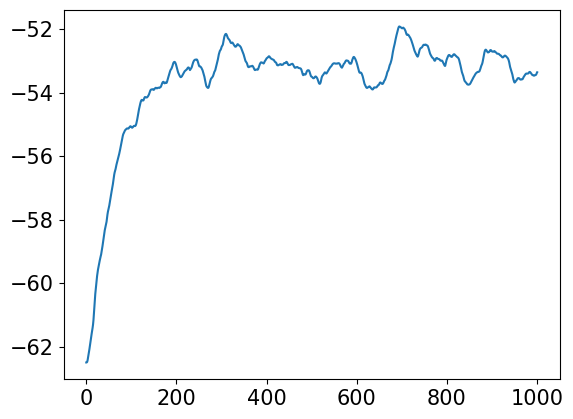

In [19]:
plt.plot(Y_train[13])

In [42]:
# delete the spike case
#Y_train = np.delete(Y_train, 1, 0)

In [20]:
Y_train.shape

(100, 1001)

In [21]:
# standardization
Y_train_std = np.empty_like(Y_train)
Y_test_std = np.empty_like(Y_test)
Y_train_std = (Y_train - np.mean(Y_train)) / np.std(Y_train)
Y_test_std = (Y_test - np.mean(Y_test)) / np.std(Y_test)

In [8]:
# Y_train = Y_train[:, ::5]
# Y_test = Y_test[:, ::5]
# Y_train_std = Y_train_std[:, ::5]
# Y_test_std = Y_test_std[:, ::5]

In [12]:
len(X_train)

900

In [14]:
time_dur

201

In [22]:
# change the input from the list to array
Nsyn = 9
time_dur = Y_train.shape[1]
def list2array(X):
    ip_dim = Nsyn
    ip_num = int(len(X) / ip_dim)
    X_array = np.zeros((ip_num, ip_dim, time_dur))
    for i in range(ip_num):
        for j in range(ip_dim):
            for spike_time in X[i*Nsyn+j]:
                if spike_time <= 3000:
                    X_array[i,j,int(spike_time)] += 1
    return X_array

X_train_array = list2array(X_train)
# X_test_array = list2array(X_test)
#X_train_array = np.delete(X_train_array, 76, 0)

# Model

In [23]:
def kernel2(tau):
    T = np.arange(time_dur)
    #y = np.heaviside(T - np.exp(delay), 0) * ((T - np.exp(delay)) / tau) * np.exp(-((T - np.exp(delay)) / tau))
    y = np.heaviside(T, 0) * (T / tau) * np.exp(-(T / tau))
    return y

def sigmoid(X, c, theta):
    y = c / (1 + np.exp(-(X - theta)))
    return y

def model_old(X, Omega, Tau, v0, c, theta):
    # X is one sample here
    Y = np.zeros(time_dur)
    for j in range(Nsyn):
        ker = kernel2(Tau[j])
        Y += Omega[j]*np.convolve(X[j], ker)[:time_dur]
    return sigmoid(Y, c, theta) + v0

def hlm_old(X, Omega, Tau, v0, c, theta):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_old(X[i], Omega, Tau, v0, c, theta)
    return Y

In [24]:
def kernel(tau_rise, tau_decay):
    T = np.arange(time_dur)
    y = (1 - np.exp(-T / tau_rise)) * np.exp(-T / tau_decay)
    return y

def sigmoid(X, c, theta):
    y = c / (1 + np.exp(-(X - theta)))
    return y

def model(X, Omega, Tau_rise, Tau_decay, K, v0):
    # X is one sample here
    Y = np.zeros(time_dur)
    L = np.zeros((Nsyn, time_dur))
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        L[i] = Omega[i]*np.convolve(X[i], ker)[:time_dur]
        Y += L[i]
        if i > 0:
            for j in range(i):
                Y += -K[int(i*(i-1)/2)+j] * L[i] * L[j]
    return Y + v0

def hlm(X, Omega, Tau_rise, Tau_decay, K, v0):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model(X[i], Omega, Tau_rise, Tau_decay, K, v0)
    return Y

In [25]:
def model_non2(X, Omega, Tau_rise, Tau_decay, v0, c, theta):
    # X is one sample here
    Y = np.zeros(time_dur)
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        Y += Omega[i]*np.convolve(X[i], ker)[:time_dur]
    return sigmoid(Y, c, theta) + v0

def hlm_non2(X, Omega, Tau_rise, Tau_decay, v0, c, theta):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_non2(X[i], Omega, Tau_rise, Tau_decay, v0, c, theta)
    return Y

In [26]:
def model_l(X, Omega, Tau_rise, Tau_decay, v0):
    # X is one sample here
    Y = np.zeros(time_dur)
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        Y += Omega[i]*np.convolve(X[i], ker)[:time_dur]
    return Y + v0

def hlm_l(X, Omega, Tau_rise, Tau_decay, v0):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_l(X[i], Omega, Tau_rise, Tau_decay, v0)
    return Y

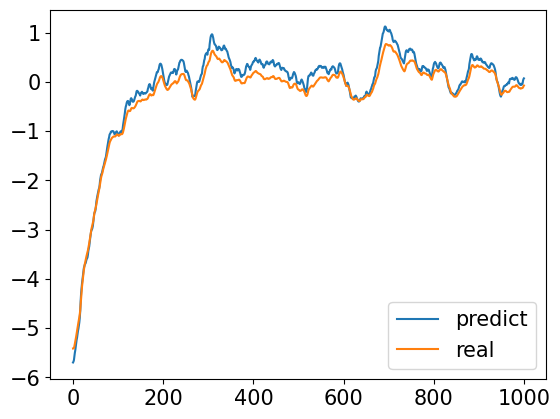

In [31]:
Vars = np.array([0.08, 0.08, 0.08, 0.08, 0.08,0.08, 0.08, 0.08, 0.08,
                 4, 4, 4, 4, 4, 4, 4, 4, 4,
                 50, 50, 50, 50, 50, 50, 50, 50, 50,
                 0.02, 
                 0.02, 0.02, 
                 0.02, 0.02, 0.02, 
                 0.02, 0.02, 0.02, 0.02, 
                 0.02, 0.02, 0.02, 0.02, 0.02, 
                 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 
                 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 
                 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
                 -5.7]) #+ np.random.randn(64) * 0.5
y = model(X_train_array[13], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63], Vars[63])
plt.plot(y, label='predict')
plt.plot(Y_train_std[13], label='real')
plt.legend()

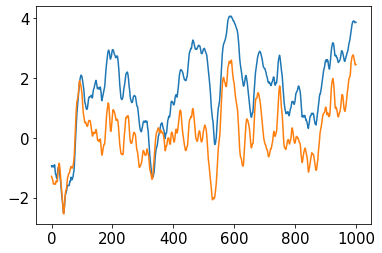

In [107]:
Vars = np.array([0.1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1,
                 15, 15, 15, 15, 15, 15, 15, 15, 15,
                 40, 40, 40, 40, 40, 40, 40, 40, 40,
                 -24, 30, -1.2])
y = model_non2(X_test_array[-1], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27], Vars[28], Vars[29])
plt.plot(y)
plt.plot(Y_test_std[-1])

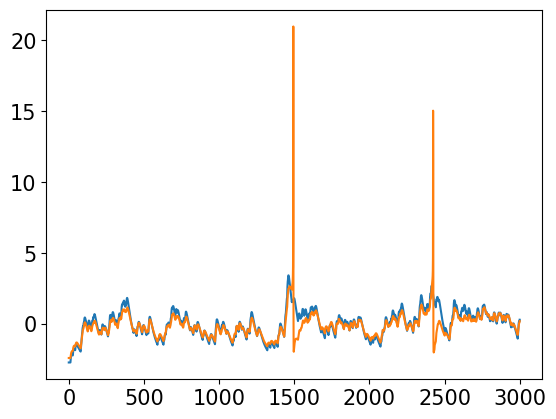

In [52]:
Vars = np.array([0.7, 0.7, 0.7,0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
                 4, 4, 4, 4, 4, 4, 4, 4, 4,
                 50, 50, 50, 50, 50, 50, 50, 50, 50,
                 -2.7])
y = model_l(X_train_array[13], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27])
plt.plot(y)
plt.plot(Y_train_std[13])

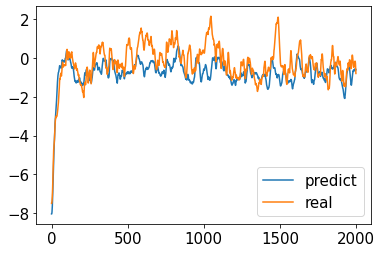

In [30]:
Vars = np.array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
                 10, 10, 10, 10, 10, 10, 10, 10, 10,
                 -32, 40, -0.4])
y = model_old(X_test_array[-1], Vars[0:9], Vars[9:18], Vars[18], Vars[19], Vars[20])
plt.plot(y, label='predict')
plt.plot(Y_test_std[-1], label='real')
plt.legend()

In [32]:
def evalVars(Vars):
    y = hlm(X_train_array, Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63], Vars[63])
    # y = model(X_train_array[13], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63], Vars[63])
    # y = model_l(X_train_array[13], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27])
    #y = hlm_non2(X_train_array, Vars[0:9], Vars[9:18], Vars[18:27], Vars[27], Vars[28], Vars[29])
    #y = hlm_l(X_train_array, Vars[0:9], Vars[9:18], Vars[18:27], Vars[27])
    #y = hlm_old(X_train_array, Vars[0:9], Vars[9:18], Vars[18], Vars[19], Vars[20])
    f = np.mean(np.square(y - Y_train_std))
    return f

In [33]:
evalVars(Vars)

0.08262100240628192

In [34]:
res = minimize(evalVars, x0=Vars, method='BFGS', options={'disp': True, 'maxiter' : 50})
# with open('pars/pars_b+b_6000ms.p', 'wb') as f:
#     pickle.dump(res.x, f)

         Current function value: 0.003409
         Iterations: 50
         Function evaluations: 4225
         Gradient evaluations: 65


In [31]:
with open('pars/pars_b+b_10Hz_active_sub_highth.p', 'rb') as fo:
    Vars = pickle.load(fo, encoding='bytes')
len(Vars)

64

In [34]:
Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63]

(array([0.83827295, 0.85052868, 0.80179661, 0.7294805 , 0.74807033,
        0.80211093, 0.79185269, 0.79898527, 0.87370513]),
 array([4.97073304, 5.16980324, 5.26765269, 3.82514844, 5.63027838,
        5.08219279, 5.63254899, 5.22369909, 5.42967368]),
 array([49.8179765 , 50.01758009, 50.03512872, 49.91236068, 50.01350019,
        49.7776923 , 50.11498149, 49.92856838, 50.12770377]),
 array([ 0.10436357,  0.03197334,  0.04882753,  0.04681117,  0.0322311 ,
         0.11243136,  0.03701848,  0.03940427,  0.05689047,  0.00586983,
         0.06273763,  0.04874608,  0.04813507,  0.00434398,  0.06547877,
         0.00608522,  0.03581752,  0.03125396,  0.02711135,  0.03998799,
         0.02006996,  0.06769962,  0.02498217,  0.02703612, -0.02246702,
         0.0674399 ,  0.0409286 ,  0.06283555,  0.02023221,  0.06377434,
         0.06634844,  0.03158801,  0.03649699,  0.01937568,  0.06674029,
         0.05505127]))

In [28]:
with open('data/training_set_op_temp_10Hz_active_spike_highth.p', 'rb') as fo:
    Y_train_ori = pickle.load(fo, encoding='bytes')

In [29]:
c = np.delete(Y_train_ori[13], np.s_[1465*5:1490*5])
t1 = np.linspace(0,3000, len(a))
t2 = np.linspace(0, 3000, len(c))

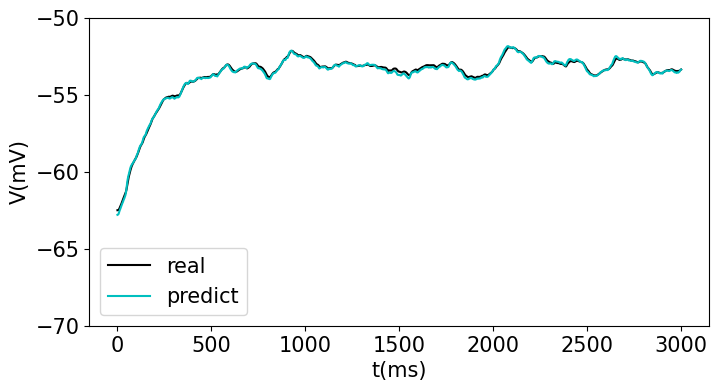

In [41]:
Vars = res.x
t = np.linspace(0, 3000, 1001)
y = model(X_train_array[13], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63], Vars[63])
plt.figure(figsize=(8, 4))
plt.plot(t, Y_train[13],color='black', label='real')
plt.plot(t, y*np.std(Y_train)+np.mean(Y_train),color='c', label='predict')
# plt.axhline(-52, c='r', ls='--')
# plt.axvline(1478, ymin=0.25, ymax=0.96, c='c', ls='--')
# plt.axvline(2416, ymin=0.2, ymax=0.96, c='c', ls='--')
plt.ylim(-70,-50)
plt.legend()
plt.xlabel('t(ms)')
plt.ylabel('V(mV)')
# plt.savefig('figure/frequency_trace', bbox_inches='tight')

In [60]:
with open('pars/pars_b+b_passive_20Hz.p', 'rb') as fo:
    Vars_bb = pickle.load(fo, encoding='bytes')
Vars_bb

array([ 5.61376830e-01,  5.81388298e-01,  5.44537181e-01,  3.87627829e-01,
        5.27549305e-01,  5.63789031e-01,  5.67258295e-01,  5.75879720e-01,
        6.17972474e-01,  7.57411707e+00,  8.31240293e+00,  8.56713453e+00,
        1.08600291e+01,  9.49857962e+00,  8.36012536e+00,  9.65296551e+00,
        8.64417616e+00,  7.83963276e+00,  5.09023492e+01,  5.10853534e+01,
        5.11219500e+01,  5.13665529e+01,  5.10595405e+01,  5.08401709e+01,
        5.11370224e+01,  5.09575356e+01,  5.08807761e+01,  4.72987608e-02,
        2.03992830e-02,  6.23086672e-02,  8.60013186e-02,  7.25934665e-02,
        1.33116931e-01,  4.18644288e-02,  4.25401999e-02,  5.20985080e-02,
        9.30152735e-02,  2.97983721e-02,  4.07006445e-02,  4.43489611e-02,
       -2.31901563e-03,  8.51175303e-02,  3.32650858e-02,  5.03478430e-02,
        6.79078827e-02, -5.63512853e-03,  4.24671452e-02,  6.29499459e-02,
        3.23107012e-02,  5.71901204e-02,  4.82414493e-02,  3.92600496e-02,
        7.04717851e-02,  